## 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import torch
from time import time
from MomentLearn import utils
from MomentLearn import model as model_utils
from MomentLearn.model import MomentLearn as Net
import prody as pd
import matplotlib.pyplot as plt
from caretta.score_functions import get_caretta_score
from caretta.multiple_alignment import tm_score
from caretta import superposition_functions, helper, multiple_alignment
import pickle
from pathlib import Path
from geometricus import MomentInvariants, SplitType, MomentType, GeometricusEmbedding
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, pairwise_distances
from glob import glob
from tqdm.notebook import tqdm
import random

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
pdb_paths = [x for x in glob("./scop_data/pdb/*")]
len(pdb_paths)

11211

In [31]:
start_time = time()
names = []
invariants = []
for i, (pdb_id) in enumerate(pdb_paths[:100]):
    names.append(pdb_id)
    if i > 0 and i % 50 == 0:
        print(f"{i} proteins fetched in {(time() - start_time):.2f} seconds")
    current = []
    pdb_obj = pd.parsePDB(pdb_id)
    current.append(MomentInvariants.from_prody_atomgroup(pdb_id, pdb_obj, split_type=SplitType.KMER, split_size=16, moment_types=list(MomentType)).moments)
    current.append(MomentInvariants.from_prody_atomgroup(pdb_id, pdb_obj, split_type=SplitType.RADIUS, split_size=12, moment_types=list(MomentType)).moments)
    current.append(MomentInvariants.from_prody_atomgroup(pdb_id, pdb_obj, split_type=SplitType.KMER, split_size=10, moment_types=list(MomentType)).moments)
    current.append(MomentInvariants.from_prody_atomgroup(pdb_id, pdb_obj, split_type=SplitType.RADIUS, split_size=8, moment_types=list(MomentType)).moments)
    invariants.append(np.hstack([((np.sign(current[i]) * np.log1p(np.abs(current[i]))) / x).astype("float32") for i, x in enumerate([16, 12, 10, 8])]))
    
    

In [6]:
no_out_channels = 16
epoch = 20_000
model = Net(invariants[0].shape[1], no_out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [7]:
current_losses = []
for e in range(epoch):
    x, dist, y = model_utils.sample_random_moment_with_close_further(invariants, jump=1,
                                                                     batch=500,
                                                                     further_min=5,
                                                                     further_max=20,
                                                                     number_of_moments=invariants[0].shape[1])

    x, dist, y = model(x, dist, y)
    loss = model_utils.loss_func(x, dist, y)
    optimizer.zero_grad()
    loss.backward()
    current_losses.append(loss.item())
    optimizer.step()
    if e % 1000 == 0:
        print(np.mean(current_losses))
        current_losses = []

4.55519962310791
0.08713187601044774
0.04645607442036271
0.04599559861049056
0.04528044731169939
0.044301574654877184
0.04363566828519106
0.04349489817395806
0.04345617381855846
0.043523367412388325
0.04329179285466671
0.043074294459074736
0.04314524231851101
0.04319572044536471
0.042745414573699236
0.04286546311527491
0.042515678592026235
0.04273950406163931
0.042625733707100155
0.04257460259273648


In [625]:
# this is to obtain hash embeddings which correspond to frequencies of shapemers in each protein
geom_embeddings = utils.get_hash_embeddings(invariants, model, nbits=16),

7921


In [9]:
# this is to obtain raw, residue based uncompressed representations.
uncompressed = [utils.moments_to_tensors(x, model) for x in invariants]

In [10]:
from caretta import dynamic_time_warping as dtw
from sklearn.metrics.pairwise import pairwise_kernels

In [27]:
some_alignment_pairs = [(random.choice(range(len(invariants))), random.choice(range(len(invariants)))) for _ in range(1000)]

caretta_scores = []
for n1, n2 in tqdm(some_alignment_pairs):
    m1, m2 = uncompressed[n1].astype(np.float64), uncompressed[n2].astype(np.float64)
    matrix = pairwise_kernels((m1), (m2), metric="cosine")
    aln_1, aln_2, score = dtw.dtw_align(matrix, 5, 0)
    caretta_scores.append(score / ((len(uncompressed[n1]) + len(uncompressed[n2]))/2))
caretta_scores = np.array(caretta_scores)

  0%|          | 0/1000 [00:00<?, ?it/s]

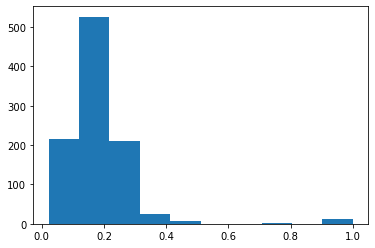

In [13]:
plt.hist(caretta_scores);


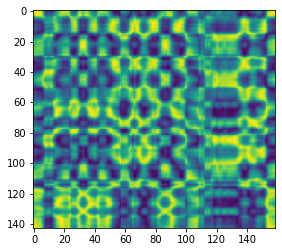

In [14]:
plt.imshow(pairwise_kernels(uncompressed[0], uncompressed[1], metric="cosine"))

In [15]:
from gensim.models import Word2Vec

In [16]:
word_model = Word2Vec(sentences=[utils.moments_to_bit_list(x, model, nbits=16) for x in invariants], vector_size=10, window=15, min_count=1, workers=4)

In [22]:
vectorized_sentences = [np.array([np.array(word_model.wv[y].mean(axis=0)).flatten() for y in utils.moments_to_bit_list(x, model, nbits=16)]) for x in invariants]

In [29]:
caretta_scores_wm = []
for n1, n2 in tqdm(some_alignment_pairs):
    m1, m2 = vectorized_sentences[n1].astype(np.float64), vectorized_sentences[n2].astype(np.float64)
    matrix = pairwise_kernels(m1, m2, metric="cosine")
    aln_1, aln_2, score = dtw.dtw_align(matrix, 5, 0)
    caretta_scores_wm.append(score / ((len(vectorized_sentences[n1]) + len(vectorized_sentences[n2]))/2))
caretta_scores_wm = np.array(caretta_scores_wm)

  0%|          | 0/1000 [00:00<?, ?it/s]

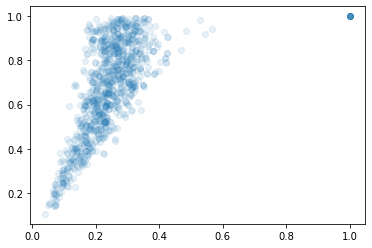

In [30]:
plt.scatter(
    caretta_scores,
    caretta_scores_wm, 
     alpha=.1)